# Моделирование технологического процесса концентрирования и извлечения золота из золотосодержащих руд

<b>Задание:</b>
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<b>Описание данных:

1) Технологический процесс:

- Rougher feed — исходное сырье;
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant:
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия);
- Rougher process (англ. «грубый процесс») — флотация;
- Rougher tails — отвальные хвосты;
- Float banks — флотационная установка;
- Cleaner process — очистка;
- Rougher Au — черновой концентрат золота;
- Final Au — финальный концентрат золота.

2) Параметры этапов:

- air amount — объём воздуха;
- fluid levels — уровень жидкости;
- feed size — размер гранул сырья;
- feed rate — скорость подачи.

3) Наименование признаков:

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:    
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

### Импорт компонентов, библиотек и модулей

Импортируем нужные компоненты, библиотеки и модули для работы:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time 
import datetime
import matplotlib.pyplot as plt

from scipy import stats as st
from tqdm.notebook import tqdm
from itertools import product

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment=None #во избежания появления предупреждения SettingWithCopy

### Загрузка датасетов, изучение данных

Загружаем исходные данные, обучающую и тестовую выборки:

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Изучаем данные по датасетам:

Датасет с исходными данными:

In [4]:
full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [5]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [6]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Датасет с обучающей выборкой: 

In [7]:
train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [9]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Датасет с тестовой выборкой:

In [10]:
test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [12]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


### Дубликаты

Проверим датасеты на дубликаты:

In [13]:
d = [full, train, test]
def check_duplicates(sheet):
    result = []
    for i in sheet:
        if i.duplicated().sum() == 0:
            result.append(0) #дубликаты отсутствуют
        else:
            result.append(1) #дубликаты присутствуют
    return result
check_duplicates(d)

[0, 0, 0]

Дубликатов в данных датасетов нет.

### Пропуски

Произведем проверку датасетов на пропуски:

In [14]:
full.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [15]:
train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [16]:
test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Произведём заполнение пропусков по условияю задачи методом ffill:

In [18]:
def mvalues(data):
    for i in data.columns:
        if data[i].isna().sum() != 0:
            data[i] = data[i].fillna(method='ffill')
    return data

In [19]:
full = mvalues(full)
train = mvalues(train)
test = mvalues(test)

Проверим:

In [20]:
full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [21]:
train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [22]:
test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Потерянные значения восстановлены. 

### Изменение типа данных

Изменим тип данных в столбце 'data' на datetime методом to_datetime(). Выведем ячейку из этого столбца для определения формата записи:

In [23]:
full['date'].head(1)

0    2016-01-15 00:00:00
Name: date, dtype: object

Дата и время указаны в формате 'год'-'месяц'-'день' 'часы':'минуты':'секунды'.

In [24]:
full['date'] = pd.to_datetime(full['date'],format='%Y-%m-%d %H:%M:%S')

Проверим корректность:

In [25]:
full['date'].head()

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]

тип данных в столбце 'data' на datetime методом to_datetime() для обучающей и тестовой выборок:

In [26]:
train['date'] = pd.to_datetime(train['date'],format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'],format='%Y-%m-%d %H:%M:%S')

Для удобства работы с данными заменим индексы во всех датафреймах на столбец 'date':

In [27]:
full.set_index('date',inplace=True)
train.set_index('date',inplace=True)
test.set_index('date',inplace=True)

### Определение отсутствующих признаков в тестовой выборке

Изучение датасетов выявило, что часть признаков в тестовой выборке отстутствует. 

Определим отсутствующие признаки:

In [28]:
missing_attrib = train.columns.difference(test.columns).tolist()

In [29]:
missing_attrib

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [30]:
def find(train, test):
    res = []
    for i in range(len(train)):
        if not (train[i] in test):
            res.append(train[i])
    return res

In [31]:
diff = find(train.columns, test.columns)
len(diff) 

34

Всего 34 признака, из них:
- 9 пропущенных признаков этапа final, 8 primary_cleaner, 9 rougher, 4 secondary_cleaner относятся к параметрам продукта;
- 4 пропущенных признака этапа rougher относятся к расчетным характеристикам;
- на всех этапах отсутствует информация о хвостовых частях;
- на всех этапах, кроме повторной очистки отсутствует информация о долях металлов;
- для финального этапа и этапа флотации отсутствуют признаки обогащения;
- отсутствуют данные о некоторых реагентах на этапе флотации.

### Восстановление данных в датасете с тестовой выборкой

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

Для успешного обучения модели, целевые признаки тестовой выборки должны быть восстановлены из датасета с исходными данными (при пересечении таблиц делаем привязку по времени):

In [33]:
test = test.merge(
    full[
        ['final.output.recovery',
         'rougher.output.recovery']
    ],
    on='date',
    how='left'
)
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [34]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
count,5290.000000,5290.000000,5290.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.842478,8.684695,7.266339,1.383430,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193,68.471462,84.997810
std,43.023252,3.073753,0.610219,0.643548,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215,9.513871,13.077651
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464,0.000000,0.000000
25%,147.121401,6.489556,6.890000,0.907390,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984,65.508598,84.509308
50%,177.828489,8.052131,7.250000,1.197586,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126,69.815413,87.388553
75%,208.125438,10.028043,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018,73.288544,89.734185
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487,100.000000,99.169699


### Проверка правильности расчётов эффективности..

Проверим правильность расчётов эффективности процесса восстановления золота из золотосодержащей руды, используя метрику MAE, на обучающей выборке:

In [37]:
recovery = pd.DataFrame.copy(train[['rougher.input.feed_au',
                                    'rougher.output.concentrate_au',
                                    'rougher.output.tail_au',
                                    'rougher.output.recovery']],
                                     deep=True
)

recovery = (recovery[(recovery['rougher.input.feed_au'].isna() == False)
                     & (recovery['rougher.output.concentrate_au'].isna() == False)
                     & (recovery['rougher.output.tail_au'].isna() == False)
                     & (recovery['rougher.output.recovery'].isna() == False)]
)                   

In [38]:
c = recovery['rougher.output.concentrate_au'] #доля золота в концентрате после флотации/очистки
f = recovery['rougher.input.feed_au'] #доля золота в сырье/концентрате до флотации/очистки
t = recovery['rougher.output.tail_au'] #доля золота в отвальных хвостах после флотации/очистки

recovery['rougher_recovery_calculated'] = c*(f-t)/(f*(c-t))*100 #эффективность обогащения

In [39]:
recovery[['rougher.output.recovery', 'rougher_recovery_calculated']].sample(10)

,rougher.output.recovery,rougher_recovery_calculated
date,,
2017-08-31 07:59:59,87.227439,87.227439
2018-08-10 15:59:59,97.828277,97.828277
2018-04-16 07:59:59,96.824345,96.824345
2017-08-21 02:59:59,89.730802,89.730802
2017-02-04 10:59:59,89.028494,89.028494
2016-04-14 18:00:00,74.497904,74.497904
2016-05-02 08:59:59,71.144087,71.144087
2016-02-27 22:00:00,89.684476,89.684476
2018-07-18 01:59:59,89.964284,89.964284


In [40]:
rougher_recovery_mae = mean_absolute_error(
    recovery['rougher_recovery_calculated'],
    recovery['rougher.output.recovery'])

print('Средняя абсолютная ошибка : {:.16f}%'.format(rougher_recovery_mae))

Средняя абсолютная ошибка : 0.0000000000000097%


Средняя абсолютная ошибка между рассчетным и заданным показателем восстановления золота практически равна нулю, что говорит о высокой точности расчёта эффективности обогащения.

### Выводы:

- Загружены датасеты с общими данными, обучающей и тестовой выборками, получена общая информация;
- Произведена предобработка данных датасетов;
- Проанализированны признаки, недоступные в тестовой выборке;
- Вычесленна эффективность обогащения золота на обучающей выборке для признака 'recovery.output.recovery'. Найдена MAE между выполненными расчётами и значением признака. Определена высокая точность расчёта эффективности обогащения золота.  

## Анализ данных

### Анализ изменения концентрации металлов на разных этапах очистки

Изучим, как меняется концентрация металлов на различных этапах очистки:

In [41]:
au_1 = full['rougher.input.feed_au'].mean()
au_2 = full['rougher.output.concentrate_au'].mean()
au_3 = full['primary_cleaner.output.concentrate_au'].mean()
au_4 = full['final.output.concentrate_au'].mean()

ag_1 = full['rougher.input.feed_ag'].mean()
ag_2 = full['rougher.output.concentrate_ag'].mean()
ag_3 = full['primary_cleaner.output.concentrate_ag'].mean()
ag_4 = full['final.output.concentrate_ag'].mean()

pb_1 = full['rougher.input.feed_pb'].mean()
pb_2 = full['rougher.output.concentrate_pb'].mean()
pb_3 = full['primary_cleaner.output.concentrate_pb'].mean()
pb_4 = full['final.output.concentrate_pb'].mean()

Содержание металлов в минеральном концентрате на разных этапах обработки


,Au,Ag,Pb
Исходное сырье,8.000,9.000,4.000
Флотация,19.772,11.995,7.606
Первичная очистка,32.119,8.442,9.810
Вторичная очистка,44.077,5.168,9.979


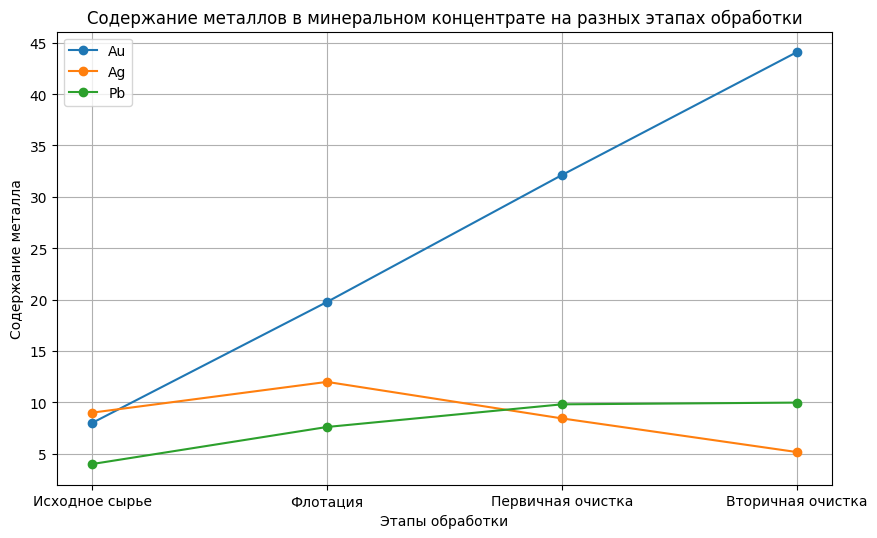

In [42]:
conc_index = pd.Series(['Исходное сырье', 'Флотация', 'Первичная очистка', 'Вторичная очистка'])
conc_data = {'Au': [round(au_1,0), round(au_2,3), round(au_3,3), round(au_4,3)],\
                 'Ag': [round(ag_1,0), round(ag_2,3), round(ag_3,3), round(ag_4,3)],\
                 'Pb': [round(pb_1,0), round(pb_2,3), round(pb_3,3), round(pb_4,3)]}

conc_df = pd.DataFrame(data = conc_data).set_index(conc_index)
print('Содержание металлов в минеральном концентрате на разных этапах обработки')
display(conc_df)

plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

for metal in conc_df.columns:
    plt.plot(conc_df.index.tolist(), conc_df.loc[:, metal], 'o-')
    
plt.legend(conc_df.columns)
plt.grid()
plt.title('Содержание металлов в минеральном концентрате на разных этапах обработки')
plt.xlabel('Этапы обработки')
plt.ylabel('Содержание металла')
plt.show()

В соответствии с графиком содержания металлов в минеральном концентрате на разных этапах очистки видно, что содержание золота на каждом этапе очистки увеличиваются почти линейно. Похожая картина наблюдается и в случае со свинцом вплоть до стадии вторичной очистки. Содержание серебра в минеральном концентрате после флотации уменьшается.

### Анализ распределения размеров гранул в выборках

Сравним распределение размера гранул исходного сырья на обучающей и тестовой выборках:

Определим значения рамеров гранул сырья в диапазоне девяностопятипроцентного квантиля:

In [43]:
train = (train
              [train['rougher.input.feed_size'] <= train['rougher.input.feed_size']
               .quantile(0.95)])
test = (test
              [test['rougher.input.feed_size'] <= test['rougher.input.feed_size']
               .quantile(0.95)])

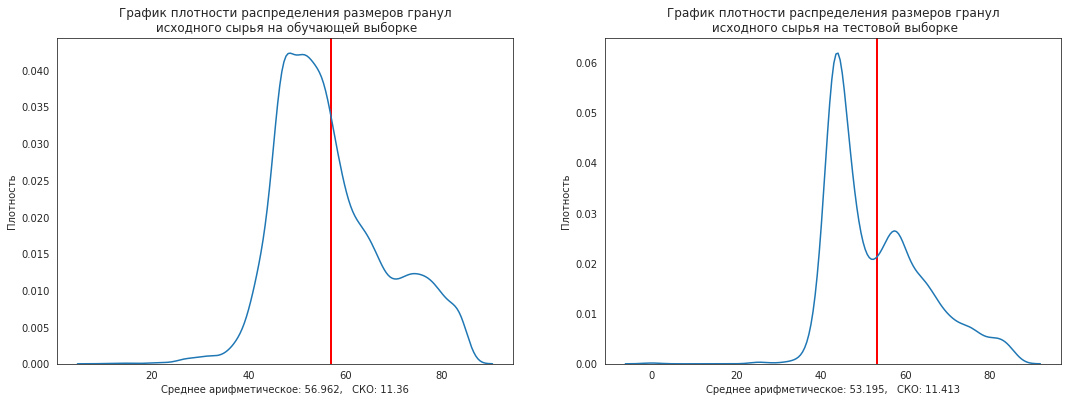

In [44]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 2)

r_train = train['rougher.input.feed_size']
r_test = test['rougher.input.feed_size']
p_train = train['primary_cleaner.input.feed_size']
p_test = test['primary_cleaner.input.feed_size']

with sns.axes_style("white"):
    ax1 = fig.add_subplot(gs[0, 0])
    plt.axvline(x=r_train.mean(), color="red", linewidth=2)
    sns.kdeplot(r_train, legend=False)
    ax1.set_title('График плотности распределения размеров гранул\n исходного сырья на обучающей выборке')
    plt.ylabel('Плотность')
    plt.xlabel('Среднее арифметическое: ' + str(round(np.mean(r_train), 3)) +\
               ',   СКО: ' + str(round(np.std(r_train), 3)))
    
with sns.axes_style("white"):
    ax2 = fig.add_subplot(gs[0, 1])
    plt.axvline(x=r_test.mean(), color="red", linewidth=2)
    sns.kdeplot(r_test, legend=False)
    ax2.set_title('График плотности распределения размеров гранул\n исходного сырья на тестовой выборке')
    plt.ylabel('Плотность')
    plt.xlabel('Среднее арифметическое: ' + str(round(np.mean(r_test), 3)) +\
               ',   СКО: ' + str(round(np.std(r_test), 3)))

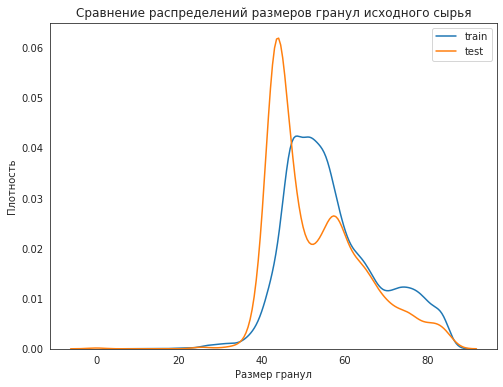

In [45]:
fig = plt.figure(figsize=(8, 6))
with sns.axes_style("white"):
    sns.kdeplot(r_train)
    sns.kdeplot(r_test)
    plt.legend(['train', 'test'])
    plt.ylabel('Плотность')
    plt.xlabel('Размер гранул')
    plt.title('Сравнение распределений размеров гранул исходного сырья')

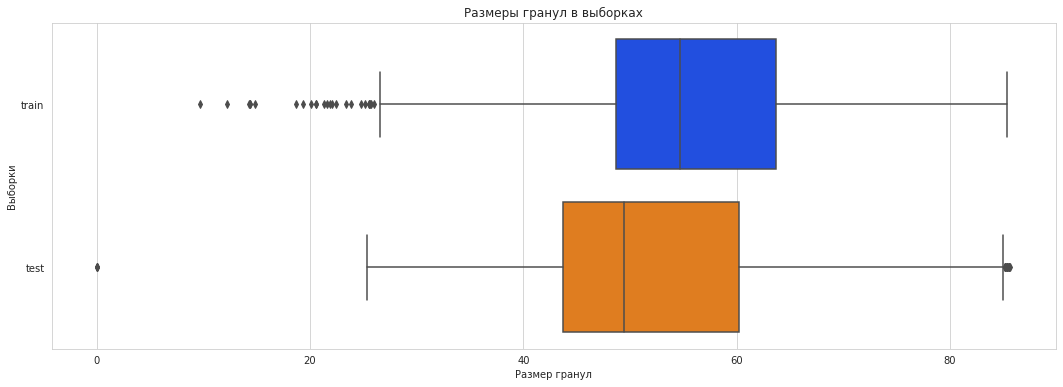

In [46]:
r_train = pd.DataFrame.copy(train, deep=True)
r_train['sample'] = 'train'

r_test = pd.DataFrame.copy(test, deep=True)
r_test['sample'] = 'test'

data_merged = pd.DataFrame.copy(r_train).append(r_test)

fig = plt.figure(figsize=(18,6))
sns.set_style("whitegrid")          
(sns.boxplot(y='sample',
             x='rougher.input.feed_size',
             data=data_merged,
             orient="h",
             palette="bright")
 .set_title('Размеры гранул в выборках'))
plt.ylabel('Выборки')
plt.xlabel('Размер гранул')
plt.show()

Распределения схожи между собой, о чем свидетельствуют приблизительно равные значения средних и квартилий на графиках. При этом, в обучающей выборке гораздо больше экстремальных значений.

### Анализ изменения суммарной концентрации всех веществ на разных этапах очистки

Исследуем суммарную концентрацию всех веществ на разных этапах очисти и построим графики для анализа распределения и выбросов:

In [47]:
full['feed_concentration_sum'] = full['rougher.input.feed_au'
                                     ]+full['rougher.input.feed_ag'
                                           ]+full['rougher.input.feed_pb'
                                                 ]+full['rougher.input.feed_sol'] # добавлено                                           
full['rougher_concentration_sum'] = full['rougher.output.concentrate_au'
                                        ]+full['rougher.output.concentrate_ag'
                                              ]+full['rougher.output.concentrate_pb'
                                                    ]+full['rougher.output.concentrate_sol']  # добавлено  
full['primary_concentration_sum'] = full['primary_cleaner.output.concentrate_au'
                                        ]+full['primary_cleaner.output.concentrate_ag'
                                              ]+full['primary_cleaner.output.concentrate_pb'
                                                    ]++full['primary_cleaner.output.concentrate_sol'] # добавлено 
full['final_concentration_sum'] = full['final.output.concentrate_au'
                                      ]+full['final.output.concentrate_ag'
                                            ]+full['final.output.concentrate_pb'
                                                  ]+full['final.output.concentrate_sol'] # добавлено 

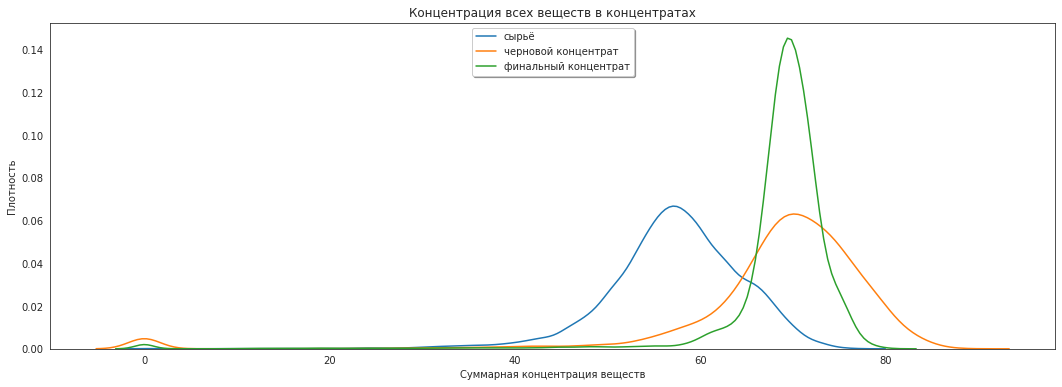

In [48]:
fig = plt.figure(figsize=(18,6))
with sns.axes_style("white"):
    sns.kdeplot(full['feed_concentration_sum'])
    sns.kdeplot(full['rougher_concentration_sum'])
    sns.kdeplot(full['final_concentration_sum'])
    plt.legend(('сырьё', 'черновой концентрат', 'финальный концентрат'),
           loc='upper center', shadow=True)
    plt.ylabel('Плотность')
    plt.xlabel('Суммарная концентрация веществ')
    plt.title('Концентрация всех веществ в концентратах')

              сырье  черновой концентрат  финальный концентрат
count  19439.000000         19439.000000          19439.000000
mean      57.320789            68.170865             68.653624
std        7.212680            12.491279              7.427536
min        0.040000             0.000000              0.000000
25%       53.557679            66.012495             67.932362
50%       57.594391            70.181495             69.598444
75%       61.953459            74.356904             71.368472
max       76.978947            88.140119             80.210644


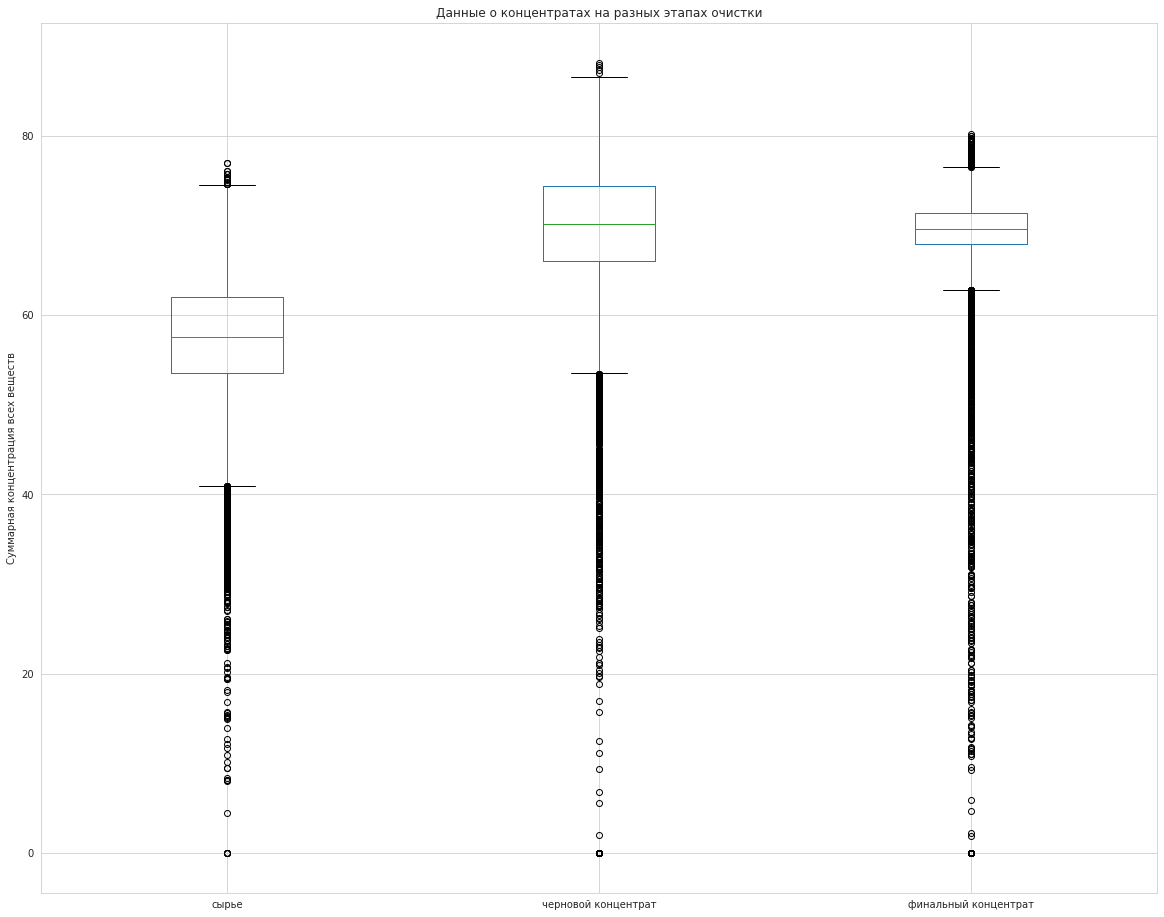

In [49]:
conc=full[[
    'feed_concentration_sum','rougher_concentration_sum','final_concentration_sum']]
conc.columns=['сырье', 'черновой концентрат', 'финальный концентрат']
print(conc.describe())
conc.plot(kind='box', figsize=(20,16))
plt.ylabel('Суммарная концентрация всех веществ')
plt.title('Данные о концентратах на разных этапах очистки')
plt.show()

Видно, что на всех этапах очистки наблюдается большое количество выбросов, при этом с каждым этапом оно только увеличивается. Также есть некоторая доля нулевых значений.

### Удаление аномальных данных

Создадим функцию и добавим данные о сумме концентрации в общую таблицу с данными:

In [50]:
def sum_conc(data,concentrat_ag,concentrat_au,concentrat_pb,concentrat_sol):
    ag=data[concentrat_ag]
    au=data[concentrat_au]
    pb=data[concentrat_pb]
    sol=data[concentrat_sol]
    sum_conc=ag+au+pb+sol
    data = sum_conc
    return data

In [51]:
full['sum_conc'] = sum_conc(full,'final.output.concentrate_ag'
                                     ,'final.output.concentrate_au'
                                     ,'final.output.concentrate_pb'
                                     ,'final.output.concentrate_sol')

Добавим значения суммы концентраций веществ в выборку data_train:

In [52]:
m_conc=full[['sum_conc']]
train = train.merge(m_conc, on='date', how='left')

In [53]:
train['sum_conc'].describe()

count    13441.000000
mean        68.446293
std          6.885130
min          0.000000
25%         67.528065
50%         69.164001
75%         71.035291
max         80.210644
Name: sum_conc, dtype: float64

Добавим значения суммы концентраций веществ в выборку data_test:

In [54]:
test = test.merge(m_conc, on='date', how='left')

In [55]:
test['sum_conc'].describe()

count    5025.000000
mean       69.508797
std         8.307599
min         0.000000
25%        69.406066
50%        70.769782
75%        72.128090
max        79.977670
Name: sum_conc, dtype: float64

Для удаления аномальных значений концентрации веществ создадим функцию:

In [56]:
def conc_clean(data,sum_concentrat,trashold):
    data=data[data[sum_concentrat] > trashold]
    plt.figure(figsize=(14,6))
    data[sum_concentrat].plot.hist(bins=100)
    plt.title('Cуммарная концентрация всех веществ')
    plt.xlabel('Значение концентрации')
    plt.ylabel('Количество значений')
    plt.grid(True)
    plt.show()
    print('Распределение данных:\n ',data[sum_concentrat].describe())
    return data

Судя по распределению значений стандартного отклонения и среднего значения, мы смело можем поставить порог в 50 для обеспечения более качественного распределения значений:

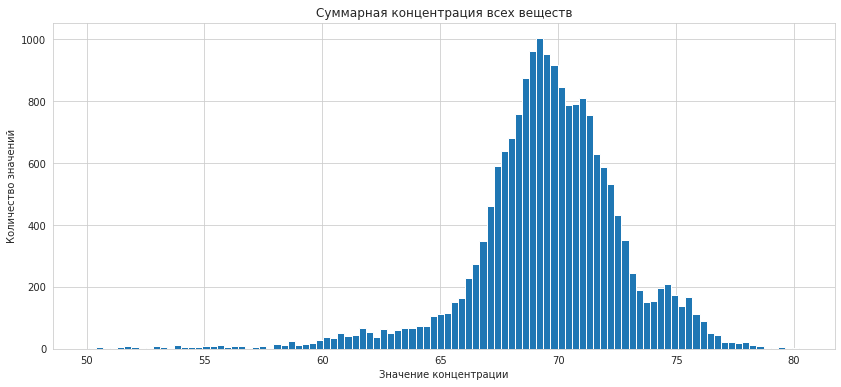

Распределение данных:
  count    19033.000000
mean        69.546324
std          3.311818
min         50.098603
25%         68.056037
50%         69.662138
75%         71.407003
max         80.210644
Name: sum_conc, dtype: float64


In [57]:
full = conc_clean(full,'sum_conc', 50)

Повторим удаление строк в тренировочной выборке:

Удалим столбцы из обучающей выборки, чтобы не вызвать переобучение модели:

In [59]:
train = train.drop(['sum_conc'], axis=1)

Выбросы удалены.

Тестовую выборку не используем, чтобы не снизить её репрезентативность.

### Выводы:

- Изучены распределения концентраций металлов на различных этапах очистки;
- Проанализированы размеры частиц. Исключены объекты, содержащие выбросы;
- Проведён сравнительный анализ распределений размеров гранул сырья на обучающей и тестовой выборках; влияние скошенностей выборок на эффективность обучения моделей незначительно;
- Найдена суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах;
- Выявлены аномальные суммарные концентрации; 
- В целях повышения качества обучения моделей аномальные объекты были исключены.

## Модель

### Вычисление итоговой sMAPE.

Напишем функцию для вычисления симметричное среднее абсолютное процентное отклонение sMAPE:

In [61]:
def smape_culc(target,predicted):
    
    return (((target - predicted).abs() / 
             ((target.abs() + predicted.abs()) / 2)).sum()
            * 100 / target.shape[0])

### Формирование признаков

#### Обучающая выборка

Убираем лишние признаки из обучающей выборки: 

In [62]:
train=train[test.columns.drop(['sum_conc'])] 

In [63]:
features_train = train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)

Проверяем наличие таргетов 'rougher.output.recovery', 'rougher_recovery_calculated','final.output.recovery' в списке признаков обучающей выборки:

In [64]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13216 entries, 2016-01-15 00:00:00 to 2018-08-18 05:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13216 non-null  float64
 1   primary_cleaner.input.depressant            13216 non-null  float64
 2   primary_cleaner.input.feed_size             13216 non-null  float64
 3   primary_cleaner.input.xanthate              13216 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13216 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13216 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13216 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13216 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13216 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1321

Теперь мы сможем использовать модель до начала тех.процесса!

Формируем таргеты для обучающей выборки:

In [65]:
rougher_target_train = train['rougher.output.recovery']
final_target_train = train['final.output.recovery']

#### Тестовая выборка.

Формируем признаки в тестовой выборке (не должна содержать целевые признаки):

In [66]:
features_test = test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)

Проверяем:

In [67]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13216 entries, 2016-01-15 00:00:00 to 2018-08-18 05:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13216 non-null  float64
 1   primary_cleaner.input.depressant            13216 non-null  float64
 2   primary_cleaner.input.feed_size             13216 non-null  float64
 3   primary_cleaner.input.xanthate              13216 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13216 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13216 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13216 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13216 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13216 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1321

Целевых признаков 'rougher.output.recovery','final.output.recovery' среди признаков тестовой выборки нет.

Формируем таргеты для обучающей выборки:

In [68]:
rougher_target_test = test['rougher.output.recovery']
final_target_test = test['final.output.recovery']

### Масштабирование признаков

Проведем масштабирование признаков обучающей выборки:

In [69]:
scaler = StandardScaler().fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))

In [70]:
features_train.shape

(13216, 52)

Для расчёта эффективности после флотации и для финальной будем использовать три модели: линейная регрессия (LinearRegression), случайное дерево (DecisionTree) и решающий лес (RandomForest).

### Построение модели для расчёта эффективности после флотации.

#### Модель линейной регрессии.

In [71]:
%%time
model = LinearRegression()
predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              rougher_target_train),
                            index=rougher_target_train.index.to_list())
best_smape_lr_r = smape_culc(rougher_target_train,predictions)

print("Наименьшее sMAPE:", best_smape_lr_r)

Наименьшее sMAPE: 12.074326991590478
CPU times: user 707 ms, sys: 1.43 s, total: 2.14 s
Wall time: 2.14 s


#### Модель решающего дерева.

In [72]:
%%time
best_parameters = 0
best_smape = 100

for parameters in tqdm(product(range(7,14),range(2,10,2),range(10,40,10))): #цикл по параметрам с помощью функции product()
    
    depth,samples_split,samples_leaf = parameters
    
    model = DecisionTreeRegressor(random_state=12345, 
                                  max_depth=depth,
                                  min_samples_split=samples_split,
                                  min_samples_leaf=samples_leaf)
    
    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              rougher_target_train),
                            index=rougher_target_train.index.to_list())
    final_smape = smape_culc(rougher_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters = parameters

best_smape_dt_r = best_smape
best_parameters_dt_r = best_parameters

print("Наименьшее sMAPE:", best_smape_dt_r,
      "\nМаксимальная глубина дерева:", best_parameters_dt_r[0],
      "\nМинимальное количество объектов в узле:", best_parameters_dt_r[1],
      "\nМинимальное количество объектов в листе:", best_parameters_dt_r[2])

0it [00:00, ?it/s]

Наименьшее sMAPE: 11.961312119151664 
Максимальная глубина дерева: 11 
Минимальное количество объектов в узле: 2 
Минимальное количество объектов в листе: 30
CPU times: user 1min 24s, sys: 402 ms, total: 1min 24s
Wall time: 1min 24s


#### Модель случайного леса.

In [73]:
%%time
best_parameters = 0
best_smape = 100

for parameters in tqdm(product(range(30,50,10),
                               range(2,8))):

    est,depth = parameters
    
    model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=est, 
                                  max_depth=depth)

    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              rougher_target_train),
                            index=rougher_target_train.index.to_list())
    
    final_smape = smape_culc(rougher_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters = parameters
        
best_smape_rf_r = best_smape
best_parameters_rf_r = best_parameters


print("Наименьшее sMAPE:", best_smape_rf_r,
      "\nКоличество деревьев", best_parameters_rf_r[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_r[1])

0it [00:00, ?it/s]

Наименьшее sMAPE: 11.147219824734245 
Количество деревьев 40 
Максимальная глубина дерева: 5
CPU times: user 4min 43s, sys: 1.55 s, total: 4min 44s
Wall time: 4min 45s


Определим с найденными лучшими гиперпараметрами оптимальное минимальное количество объектов в узле и листе "min_samples_split" и "min_samples_leaf":

In [74]:
%%time
best_parameters = [best_parameters_rf_r[0],best_parameters_rf_r[1],0,0]
best_smape = 100

for parameters in tqdm(product(range(2,10,2),
                               range(2,10,2))):
    
    samples_split,samples_leaf = parameters
    
    model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=best_parameters_rf_r[0], 
                                  max_depth=best_parameters_rf_r[1],
                                  min_samples_split=samples_split,
                                  min_samples_leaf=samples_leaf)
    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              rougher_target_train),
                            index=rougher_target_train.index.to_list())
    final_smape = smape_culc(rougher_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters[2] = parameters[0]
        best_parameters[3] = parameters[1]



best_smape_rf_r = best_smape
best_parameters_rf_r = best_parameters


print("Наименьшее sMAPE:", best_smape_rf_r,
      "\nКоличество деревьев", best_parameters_rf_r[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_r[1],
      "\nМинимальное коичество объектов в узле:", best_parameters_rf_r[2],
      "\nМинимальное коичество объектов в листе:", best_parameters_rf_r[3])

0it [00:00, ?it/s]

Наименьшее sMAPE: 11.051556639638541 
Количество деревьев 40 
Максимальная глубина дерева: 5 
Минимальное коичество объектов в узле: 2 
Минимальное коичество объектов в листе: 8
CPU times: user 7min 52s, sys: 2.21 s, total: 7min 54s
Wall time: 7min 56s


### Построение модели для финальной эффективности:

#### Модель линейной регрессии. 

In [75]:
%%time
model = LinearRegression()

predictions = pd.Series(cross_val_predict(model,
                                          features_train,
                                          final_target_train),
                    index=final_target_train.index.to_list())
best_smape_lr_f = smape_culc(final_target_train,predictions)

print("Наименьшее sMAPE:", best_smape_lr_f)

Наименьшее sMAPE: 11.107427337996317
CPU times: user 765 ms, sys: 1.2 s, total: 1.97 s
Wall time: 1.94 s


#### Модель решающего дерева.

In [76]:
%%time
best_parameters = 0
best_smape = 100

for parameters in tqdm(product(range(7,14),range(2,8,2),range(5,20,5))):
    
    depth,samples_split,samples_leaf = parameters
    
    model = DecisionTreeRegressor(random_state=12345, 
                                  max_depth=depth,
                                  min_samples_split=samples_split,
                                  min_samples_leaf=samples_leaf)
    
    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              final_target_train),
                            index=final_target_train.index.to_list())
    final_smape = smape_culc(final_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters = parameters
        

best_smape_dt_f = best_smape
best_parameters_dt_f = best_parameters

print("Наименьшее sMAPE:", best_smape_dt_f,
      "\nМаксимальная глубина дерева:", best_parameters_dt_f[0],
      "\nМинимальное количество объектов в узле:", best_parameters_dt_f[1],
      "\nМинимальное количество объектов в листе:", best_parameters_dt_f[2])

0it [00:00, ?it/s]

Наименьшее sMAPE: 11.214199591550766 
Максимальная глубина дерева: 11 
Минимальное количество объектов в узле: 2 
Минимальное количество объектов в листе: 10
CPU times: user 1min 5s, sys: 396 ms, total: 1min 5s
Wall time: 1min 5s


#### Модель случайного леса.

In [77]:
%%time
best_parameters = 0
best_smape = 100

for parameters in tqdm(product(range(30,50,10),
                               range(11,14))):

    est,depth = parameters
    
    model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=est, 
                                  max_depth=depth)

    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              final_target_train),
                            index=final_target_train.index.to_list())
    
    final_smape = smape_culc(final_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters = parameters
        
best_smape_rf_f = best_smape
best_parameters_rf_f = best_parameters


print("Наименьшее sMAPE:", best_smape_rf_f,
      "\nКоличество деревьев", best_parameters_rf_f[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_f[1])

0it [00:00, ?it/s]

Наименьшее sMAPE: 9.487022514550748 
Количество деревьев 40 
Максимальная глубина дерева: 11
CPU times: user 5min 16s, sys: 1.95 s, total: 5min 17s
Wall time: 5min 18s


Определим с найденными лучшими гиперпараметрами оптимальное минимальное количество объектов в узле и листе "min_samples_split" и "min_samples_leaf":

In [78]:
%%time
best_parameters = [best_parameters_rf_f[0],best_parameters_rf_f[1],0,0]
best_smape = 100

for parameters in tqdm(product(range(2,10,2), 
                               range(2,10,2))):
    
    samples_split,samples_leaf = parameters
    
    model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=best_parameters_rf_f[0], 
                                  max_depth=best_parameters_rf_f[1],
                                  min_samples_split=samples_split,
                                  min_samples_leaf=samples_leaf)
    predictions = pd.Series(cross_val_predict(model,
                                              features_train,
                                              final_target_train),
                            index=final_target_train.index.to_list())
    final_smape = smape_culc(final_target_train,predictions)
    
    if final_smape < best_smape:
        best_smape = final_smape   
        best_parameters[2] = parameters[0]
        best_parameters[3] = parameters[1]


best_smape_rf_f = best_smape
best_parameters_rf_f = best_parameters

print("Наименьшее sMAPE:", best_smape_rf_f,
      "\nКоличество деревьев", best_parameters_rf_f[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_f[1],
      "\nМинимальное коичество объектов в узле:", best_parameters_rf_f[2],
      "\nМинимальное коичество объектов в листе:", best_parameters_rf_f[3])

0it [00:00, ?it/s]

Наименьшее sMAPE: 9.213439458008555 
Количество деревьев 40 
Максимальная глубина дерева: 11 
Минимальное коичество объектов в узле: 2 
Минимальное коичество объектов в листе: 8
CPU times: user 14min 42s, sys: 3.65 s, total: 14min 46s
Wall time: 14min 47s


Оценим значения итогового sMAPE для каждой из обученных моделей, добавим их в отдельный DataFrame:

In [79]:
def smape_final_score(smape_rougher, smape_final):
    smape_final = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_final

In [80]:
results = [['Линейная регрессия', smape_final_score(best_smape_lr_r, best_smape_lr_f)],
               ['Решающее дерево', smape_final_score(best_smape_dt_r, best_smape_dt_f)],
               ['Случайный лес', smape_final_score(best_smape_rf_r, best_smape_rf_f)]     
          ]           
data_results = pd.DataFrame(data=results, columns=['Модель', 'Финальный sMAPE'])
data_results

,Модель,Финальный sMAPE
0,Линейная регрессия,11.349152
1,Решающее дерево,11.400978
2,Случайный лес,9.672969


Наилучший результат по sMAPE показала модель случайного леса. 

### Проверка на тестовой выборке.

#### Для эффективности после флотации.

Наименьшее sMAPE дала модель случайного леса со следующими гиперпараметрами:

In [81]:
print("Наименьшее sMAPE:", best_smape_rf_r,
      "\nКоличество деревьев", best_parameters_rf_r[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_r[1],
      "\nМинимальное коичество объектов в узле:", best_parameters_rf_r[2],
      "\nМинимальное коичество объектов в листе:", best_parameters_rf_r[3])

Наименьшее sMAPE: 11.051556639638541 
Количество деревьев 40 
Максимальная глубина дерева: 5 
Минимальное коичество объектов в узле: 2 
Минимальное коичество объектов в листе: 8


Обучим эту модель и найдем значение метрики sMAPE на тестовой выборке:

In [82]:
%%time
model = RandomForestRegressor(
                                  random_state=12345, 
                                  n_estimators=best_parameters_rf_r[0], 
                                  max_depth=best_parameters_rf_r[1],
                                  min_samples_split=best_parameters_rf_r[2],
                                  min_samples_leaf=best_parameters_rf_r[3])

model.fit(features_test,rougher_target_test)

predictions_test_r = pd.Series(model.predict(features_test),index=features_test.index.to_list())

smape_culc(rougher_target_test, predictions_test_r)

CPU times: user 2.66 s, sys: 20 ms, total: 2.68 s
Wall time: 2.69 s


7.108459482234585

Проверка работы модели на адекватность.

Для этого сравним полученную метрику sMAPE с метрикой для константной модели.

Запишем в переменные mean_target и median_target объекты Series со средними и медианными значениями целевого признака из обучающей выборки соответственно:

In [83]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train,rougher_target_train)

mean_target_rougher = pd.Series(dummy_regr.predict(features_test),
                        index = features_test.index.to_list())

In [84]:
dummy_regr = DummyRegressor(strategy="median")

dummy_regr.fit(features_train,rougher_target_train)

median_target_rougher = pd.Series(dummy_regr.predict(features_test),
                          index = features_test.index.to_list())

Найдем sMAPE для среднего и медианного значений:

In [85]:
print('Метрика sMAPE для среднего:',
      round(smape_culc(rougher_target_test,
                       mean_target_rougher),2))

Метрика sMAPE для среднего: 10.48


In [86]:
print('Метрика sMAPE для медианы:',
      round(smape_culc(rougher_target_test,
           median_target_rougher),2))

Метрика sMAPE для медианы: 8.73


Метрика sMAPE для модели случайного леса, равная 6,71 %, значительно меньше, чем у константных моделей со средним и медианным значениями. Модель предсказывает лучше константных моделей и имеет смысл.

#### Для финальной эффективности.

Наименьшее sMAPE дала модель случайного леса со следующими гиперпараметрами:

In [87]:
print("Наименьшее sMAPE:", best_smape_rf_f,
      "\nКоличество деревьев", best_parameters_rf_f[0],
      "\nМаксимальная глубина дерева:", best_parameters_rf_f[1],
      "\nМинимальное коичество объектов в узле:", best_parameters_rf_f[2],
      "\nМинимальное коичество объектов в листе:", best_parameters_rf_f[3])

Наименьшее sMAPE: 9.213439458008555 
Количество деревьев 40 
Максимальная глубина дерева: 11 
Минимальное коичество объектов в узле: 2 
Минимальное коичество объектов в листе: 8


Обучим эту модель и найдем значение метрики sMAPE на тестовой выборке:

In [88]:
%%time
model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=best_parameters_rf_f[0], 
                                  max_depth=best_parameters_rf_f[1],
                                  min_samples_split=best_parameters_rf_f[2],
                                  min_samples_leaf=best_parameters_rf_f[3])

model.fit(features_test,final_target_test)

predictions_test_f = pd.Series(model.predict(features_test),index=features_test.index.to_list())

smape_culc(final_target_test, predictions_test_f)

CPU times: user 5.17 s, sys: 16 ms, total: 5.18 s
Wall time: 5.19 s


5.9657881216368125

Аналогично проверим работу модели на адекватность. Для этого сравним полученную метрику sMAPE с метрикой для константной модели.

Запишем в переменные mean_target_final и median_target_final объекты Series со средними и медианными значениями целевого признака из обучающей выборки соответственно:

In [89]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train,final_target_train)

mean_target_final = pd.Series(dummy_regr.predict(features_test),
                        index = features_test.index.to_list())

In [90]:
dummy_regr = DummyRegressor(strategy="median")

dummy_regr.fit(features_train,final_target_train)

median_target_final = pd.Series(dummy_regr.predict(features_test),
                        index = features_test.index.to_list())

Найдем sMAPE для среднего и медианного значений:

In [91]:
print('Метрика sMAPE для среднего:',
      round(smape_culc(final_target_test,
                       mean_target_final),2))

Метрика sMAPE для среднего: 10.02


In [92]:
print('Метрика sMAPE для медианы:',
      round(smape_culc(final_target_test,
           median_target_final),2))

Метрика sMAPE для медианы: 9.68


Метрика sMAPE для модели случайного леса, равная 5,97 %, значительно меньше, чем у константных моделей со средним и медианным значениями. Модель предсказывает лучше константных моделей и имеет смысл.

 ### Выводы:

- Введены функции:
        - Вычисления метрики sMAPE для стадий флотации и финальной обработки;
        - Вычисления метрики итогового sMAPE;
        - Кросс-валидации с использованием метрики sMAPE;
- Обучены модели:
        - LinearRegression;
        - DecisionTreeRegressor;
        - RandomForestRegressor;       
- Получена итоговая оценка sMAPE для каждой модели, найдены оптимальные наборы гиперпараметров;
- В качестве финальной выбрана модель RandomForestRegressor;
- Эффективность обученной модели доказана сравнением с константной моделью по метрике sMAPE.

## Общие выводы.

- Загружены датасеты с общими данными, обучающей и тестовой выборками, получена общая информация;
- Произведена предобработка данных датасетов;
- Проанализированны признаки, недоступные в тестовой выборке;
- Вычесленна эффективность обогащения золота на обучающей выборке для признака 'recovery.output.recovery'. Найдена MAE между выполненными расчётами и значением признака. Определена высокая точность расчёта эффективности обогащения золота;
- Изучены распределения концентраций металлов на различных этапах очистки;
- Проанализированы размеры частиц. Исключены объекты, содержащие выбросы;
- Проведён сравнительный анализ распределений размеров гранул сырья на обучающей и тестовой выборках; влияние скошенностей выборок на эффективность обучения моделей незначительно;
- Найдена суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах;
- Выявлены аномальные суммарные концентрации; 
- В целях повышения качества обучения моделей аномальные объекты были исключены;
- Введены функции:
        - Вычисления метрики sMAPE для стадий флотации и финальной обработки;
        - Вычисления метрики итогового sMAPE;
        - Кросс-валидации с использованием метрики sMAPE;
- Обучены модели:
        - LinearRegression;
        - DecisionTreeRegressor;
        - RandomForestRegressor;       
- Получена итоговая оценка sMAPE для каждой модели, найдены оптимальные наборы гиперпараметров;
- В качестве финальной выбрана модель RandomForestRegressor;
- Эффективность обученной модели доказана сравнением с константной моделью по метрике sMAPE.